In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_waveguide_column(A0, penalize_indices):
    # Ensure A0 is a complex array
    A0 = np.array(A0, dtype=complex)
    
    # Define the objective function
    def objective(params):
        k = 0.01
        phi = params[0:6]
        
        beta = 1
        z = np.pi / (2 * k)
        k13 = 0.01 * k
        
        M1 = np.array([[beta + phi[0], k, k13],
                       [k, beta + phi[1], k],
                       [k13, k, beta + phi[2]]], dtype=complex)
        M2 = np.array([[beta + phi[3], k, k13],
                       [k, beta + phi[4], k],
                       [k13, k, beta + phi[5]]], dtype=complex)
        # Apply the matrices sequentially
        A_z = A0 @ expm(-1j * M1 * z)
        A_z = A_z @ expm(-1j * M2 * z)
        #A_z = A_z @ expm(-1j * M3 * z)
        #A_z = A_z @ expm(-1j * M4 * z)
        
        # Strongly penalize specified indices
        penalty = sum(1e6 * np.abs(A_z[i]) for i in penalize_indices)
        return np.sum(np.abs(A_z[penalize_indices])**2) + penalty

    # Initial guess for k, phi values
    initial_guess =  [0.0] * 6

    # Bounds for the variables
    bounds =  [(-0.01, 0.01)] * 6

    # Perform the optimization using differential evolution method which handles global optimization
    result = differential_evolution(objective, bounds)
    optimal_params = result.x

    # Extract optimized parameters
    
    optimal_phi = optimal_params[0:6]
    z = np.pi / (2 * 0.01)

    # Compute the final A(z) with the optimal parameters
    beta = 1
    k = 0.01
    k13 = 0.01 * k

    M1_optimal = np.array([[beta + optimal_phi[0], k, k13],
                           [k, beta + optimal_phi[1], k],
                           [k13, k, beta + optimal_phi[2]]], dtype=complex)
    M2_optimal = np.array([[beta + optimal_phi[3], k, k13],
                           [k, beta + optimal_phi[4], k],
                           [k13, k, beta + optimal_phi[5]]], dtype=complex)
    

    A_z_optimal = A0 @ expm(-1j * M1_optimal * z)
    A_z_optimal = A_z_optimal @ expm(-1j * M2_optimal * z)
    
  

    M_optimal = (M1_optimal * z + M2_optimal  * z)

    # Compute power distribution
    power_distribution = np.abs(A_z_optimal)**2

    # Print the final optimized parameters and A(z)
    
    print("Optimal phi values:", optimal_phi)
    print("Optimal z:", z)
    print("Optimal M1 matrix:")
    print(M1_optimal)
    print("Optimal M2 matrix:")
    print(M2_optimal)
    print("Power distribution:", power_distribution)

    # Visualize the results
    plt.figure(figsize=(12, 10))

    plt.subplot(1, 2, 1)
    sns.heatmap(M1_optimal.real, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title("Optimized Matrix $M1$")

    plt.subplot(1, 2, 2)
    sns.heatmap(M2_optimal.real, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title("Optimized Matrix $M2$")


    plt.tight_layout()
    plt.show()

    plt.figure()
    A_z_real = np.real(A_z_optimal)
    A_z_imag = np.imag(A_z_optimal)
    bar_width = 0.35
    index = np.arange(3)
    plt.bar(index, A_z_real, bar_width, label='Real')
    plt.bar(index + bar_width, A_z_imag, bar_width, label='Imaginary')
    plt.xlabel('Components')
    plt.ylabel('Values')
    plt.title('$A(z)$ Components')
    plt.xticks(index + bar_width / 2, ['A1', 'A2', 'A3'])
    plt.legend()
    plt.show()

    plt.figure()
    plt.bar(index, power_distribution, color=['blue', 'green', 'red'])
    plt.xlabel('Waveguides')
    plt.ylabel('Power')
    plt.title('Power Distribution')
    plt.xticks(index, ['A1', 'A2', 'A3'])
    plt.show()

    return A_z_optimal, M1_optimal, M2_optimal, z


In [2]:
import numpy as np

# Function to compute the n-point DFT matrix
def dft_matrix(n):
    omega = np.exp(-2j * np.pi / n)
    return np.array([[omega ** (i * j) for j in range(n)] for i in range(n)])

# Function to check if a matrix is unitary
def is_unitary(matrix):
    identity = np.eye(matrix.shape[0])
    product = np.dot(matrix, np.conjugate(matrix.T))
    return np.allclose(product, identity, atol=1e-7)

# Generate the 3-point DFT matrix
n = 3
dft_mat = dft_matrix(n)
print("3-point DFT matrix:")
print(dft_mat)

# Compute the determinant manually
a = dft_mat[0, 0]
b = dft_mat[0, 1]
c = dft_mat[0, 2]
d = dft_mat[1, 0]
e = dft_mat[1, 1]
f = dft_mat[1, 2]
g = dft_mat[2, 0]
h = dft_mat[2, 1]
i = dft_mat[2, 2]

determinant_manual = (
    a * (e * i - f * h)
    - b * (d * i - f * g)
    + c * (d * h - e * g)
)



# Compute the determinant using numpy
dft_mat=dft_mat/np.sqrt(3)
determinant_numpy = np.linalg.det(dft_mat)
print("Determinant (numpy calculation):", np.abs(determinant_numpy))

# Check if the matrix is unitary
unitary = is_unitary(dft_mat)
print("Is unitary:", unitary)


3-point DFT matrix:
[[ 1. +0.j         1. +0.j         1. +0.j       ]
 [ 1. +0.j        -0.5-0.8660254j -0.5+0.8660254j]
 [ 1. +0.j        -0.5+0.8660254j -0.5-0.8660254j]]
Determinant (numpy calculation): 1.0000000000000002
Is unitary: True


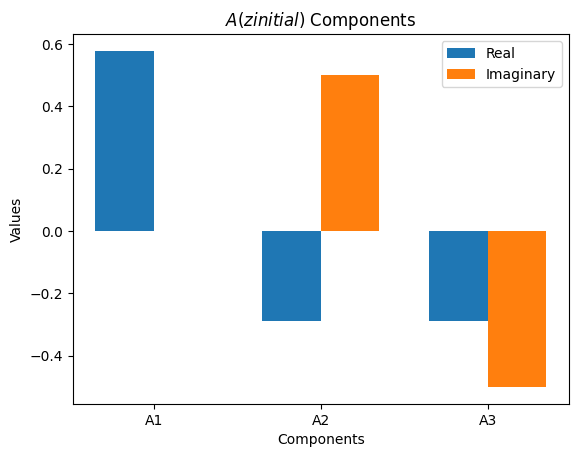

In [22]:
plt.figure()
A_z_real = np.real(dft_mat[2])
A_z_imag = np.imag(dft_mat[2])
bar_width = 0.35
index = np.arange(3)
plt.bar(index, A_z_real, bar_width, label='Real')
plt.bar(index + bar_width, A_z_imag, bar_width, label='Imaginary')
plt.xlabel('Components')
plt.ylabel('Values')
plt.title('$A(z initial)$ Components')
plt.xticks(index + bar_width / 2, ['A1', 'A2', 'A3'])
plt.legend()
plt.show()

In [4]:
dft_mat[0][0]

(0.5773502691896258+0j)

Optimal phi values: [ 0.00198893  0.00113958 -0.00786414  0.00776661 -0.00209781 -0.00678403]
Optimal z: 157.07963267948966
Optimal M1 matrix:
[[1.00198893e+00+0.j 1.00000000e-02+0.j 1.00000000e-04+0.j]
 [1.00000000e-02+0.j 1.00113958e+00+0.j 1.00000000e-02+0.j]
 [1.00000000e-04+0.j 1.00000000e-02+0.j 9.92135864e-01+0.j]]
Optimal M2 matrix:
[[1.00776661e+00+0.j 1.00000000e-02+0.j 1.00000000e-04+0.j]
 [1.00000000e-02+0.j 9.97902193e-01+0.j 1.00000000e-02+0.j]
 [1.00000000e-04+0.j 1.00000000e-02+0.j 9.93215972e-01+0.j]]
Power distribution: [4.23126809e-31 1.60256631e-30 1.00000000e+00]


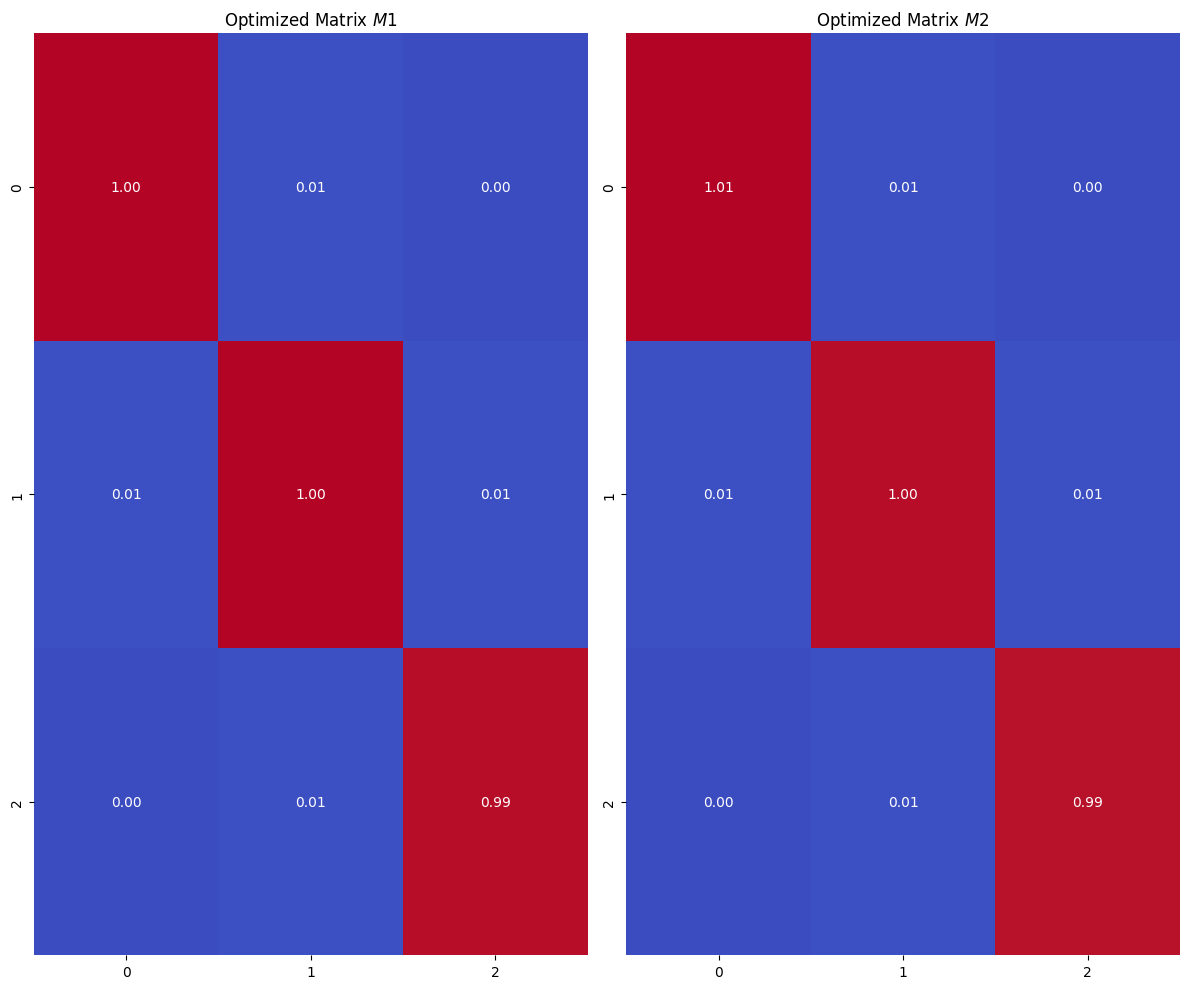

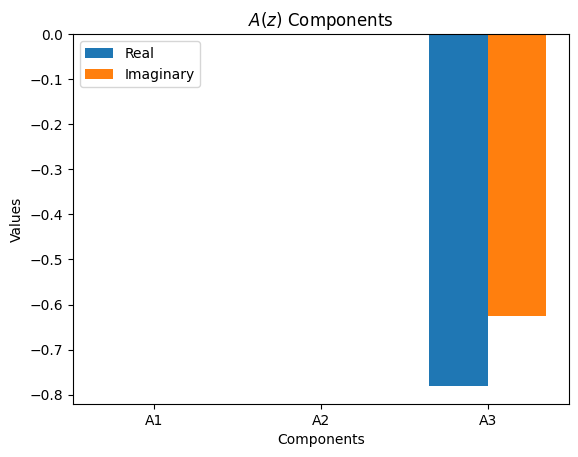

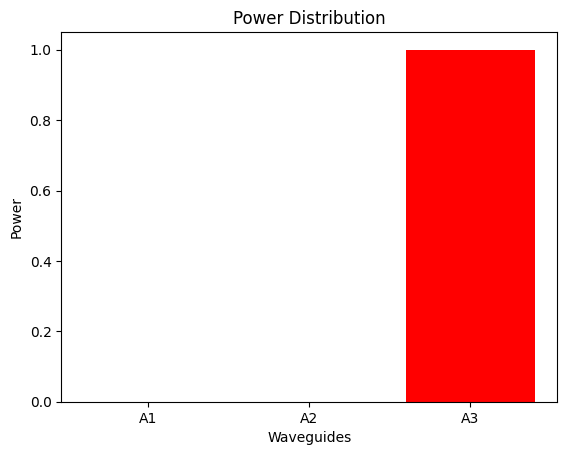

In [5]:

A_1 = np.array([dft_mat[2][0], dft_mat[2][1], dft_mat[2][2]])

# Optimize the waveguide column for nullifying (2,0) and (2,1)
A_1f, M1, M2, z1 = optimize_waveguide_column(A_1, [0, 1])


In [15]:
# Apply the transformation matrices (first iteration)
dft_mat = dft_mat @ expm(-1j * M1 * z1)
dft_mat = dft_mat @ expm(-1j * M2 * z1)


# Print the transformed matrix after first iteration
print("Transformed matrix after first iteration:\n", dft_mat)


Transformed matrix after first iteration:
 [[ 7.08015574e-01-3.18302602e-02j  3.14839722e-01+6.31329336e-01j
   8.24340596e-15-1.42663659e-14j]
 [-5.46928129e-01-4.45612391e-01j -1.86305916e-01+6.83805034e-01j
  -7.96585020e-15+2.72004641e-15j]
 [ 1.27675648e-15+8.04911693e-16j -2.27595720e-15-2.22044605e-16j
  -9.99988819e-01-4.72885335e-03j]]


Text(0.5, 1.0, 'Optimized Matrix $M1$')

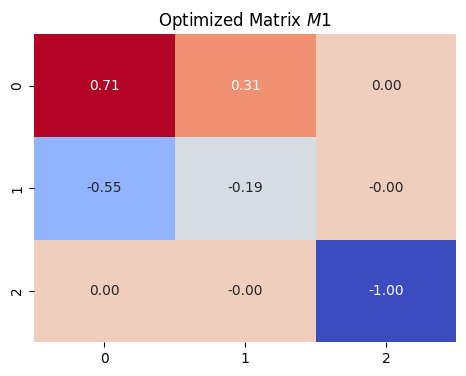

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(dft_mat.real, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Matrix after tranformation")